In [1]:
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
"""
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
"""
# gpus = tf.config.list_physical_devices('GPU')
# gpus
#
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12000)])
#   except RuntimeError as e:
#     print(e)

val_performance = {}
performance = {}
val_performance_mae = {}
performance_mae = {}
multi_val_performance = {}
multi_performance = {}
multi_val_performance_mae = {}
multi_performance_mae = {}


2023-01-12 16:45:50.758089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 16:45:51.855179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-12 16:45:51.855253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-12 16:45:51.855259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [121]:
!pip install pydot

You should consider upgrading via the '/home/jamesmayr/Documents/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def get_cloned_model(model_to_clone,optimizer):
    model_copy= tf.keras.models.clone_model(model_to_clone)
    #model_copy.build((None, 10)) # replace 10 with number of variables in input layer
    model_copy.compile(optimizer=optimizer, loss='mse')
    model_copy.set_weights(model_to_clone.get_weights())
    return model_copy

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import copy
import datetime

class PerformancePlot():
    def plot_test_train(self,name,predicted_train_y,predicted_test_y,wg, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        if wg.moving_average_transformer is not None:
            wg = copy.copy(wg)
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()


        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            performance[name] = rsme_train
            val_performance[name] = rsme_test
            performance_mae[name] = mae_train
            val_performance_mae[name] = mae_test


        plt.subplot(1, 2, 1)
        plt.title("Train "+name)
        plt.plot(x["DaysInYear"], y)
        plt.plot(x["DaysInYear"], predicted_train_y)
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y)
        plt.plot(t_x["DaysInYear"], predicted_test_y)
        plt.grid(True)
    def plot_test_train_multistep2(self,name,predicted_train_y,predicted_test_y, wg, steps, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        tf_x = None
        tf_y = None
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.calc_window()
            f_x,f_y = wg.get_xy_test()
            tf_x,tf_y = wg.get_xy_test()
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            multi_performance[name] = rsme_train
            multi_val_performance[name] = rsme_test
            multi_performance_mae[name] = mae_train
            multi_val_performance_mae[name] = mae_test


        plt.subplot(2, 1, 1)
        plt.title("Train "+name)

        plt.plot(x["DaysInYear"], y.to_numpy()[:,0])
        train_pred_plot = []
        for i in range(predicted_train_y.shape[0])[::steps]:
            train_pred_plot += predicted_train_y[i].tolist()

        plt.plot(x["DaysInYear"], train_pred_plot[:x["DaysInYear"].shape[0]])
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y.to_numpy()[:,0])
        if tf_x is not None:
            plt.plot(tf_x["DaysInYear"], tf_y.to_numpy()[:,0])
        test_pred_plot = []
        for i in range(predicted_test_y.shape[0])[::steps]:
            test_pred_plot += predicted_test_y[i].tolist()
        plt.plot(t_x["DaysInYear"], test_pred_plot[:t_x["DaysInYear"].shape[0]])

        plt.grid(True)

    def plot_test_train_multistep(self,name,predicted_train_y,predicted_test_y, wg, steps, save_to_performance_measurement=True):
        plt.figure(figsize=(20, 10))

        print(name)
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.moving_average_transformer = None


        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)
        if save_to_performance_measurement:
            multi_performance[name] = rsme_train
            multi_val_performance[name] = rsme_test
            multi_performance_mae[name] = mae_train
            multi_val_performance_mae[name] = mae_test


        plt.subplot(2, 1, 1)
        plt.title("Train "+name)

        plt.plot(x["DaysInYear"], y.to_numpy()[:,0])

        for i in range(len(x["DaysInYear"])-steps):
            plt.plot(x["DaysInYear"][i:i+steps], predicted_train_y[i])

        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.title("Test "+name)
        plt.plot(t_x["DaysInYear"], t_y.to_numpy()[:,0])

        for i in range(len(t_x["DaysInYear"])-steps):
            plt.plot(t_x["DaysInYear"][i:i+steps], predicted_test_y[i])
        plt.grid(True)

    def plot_test_train_multistep3(self,name,predicted_train_y,predicted_test_y, wg,model_statistic,save_fig=False,xlim=None):
        plt.figure(figsize=(20, 10))

        print(name)
        tf_x = None
        tf_y = None
        if wg.moving_average_transformer is not None:

            wg = copy.copy(wg)
            wg.calc_window()
            f_x,f_y = wg.get_xy_test()
            tf_x,tf_y = wg.get_xy_test()
            wg.moving_average_transformer = None

        wg.calc_window()
        x,y = wg.get_xy_train()
        t_x,t_y = wg.get_xy_test()

        rsme_train = np.sqrt(mean_squared_error(y,predicted_train_y))
        rsme_test = np.sqrt(mean_squared_error(t_y,predicted_test_y))
        mae_train = mean_absolute_error(y,predicted_train_y)
        mae_test = mean_absolute_error(t_y,predicted_test_y)
        model_statistic.add(rsme_test)

        print("RSME Train:",rsme_train)
        print("RSME Test:",rsme_test)
        print("MAE Train:",mae_train)
        print("MAE Test:",mae_test)

        plt.title(name+" "+str(wg.item_no))
        plt.plot(y.to_numpy()[:,0],c='#1f77b4')

        train_samples = x["DaysInYear"].shape[0]
        test_samples = t_x["DaysInYear"].shape[0]

        train_pred_plot = []
        for i in range(predicted_train_y.shape[0])[::wg.steps]:
            train_pred_plot += predicted_train_y[i].tolist()

        plt.plot(train_pred_plot[:x["DaysInYear"].shape[0]],c='#ff7f0e')
        plt.grid(True)

        plt.plot(range(train_samples,train_samples+test_samples), t_y.to_numpy()[:,0],c='#1f77b4')
        if tf_x is not None:
            plt.plot(range(train_samples,train_samples+test_samples), tf_y.to_numpy()[:,0])
        test_pred_plot = []
        for i in range(predicted_test_y.shape[0])[::wg.steps]:
            test_pred_plot += predicted_test_y[i].tolist()
        plt.plot(range(train_samples,train_samples+test_samples), test_pred_plot[:t_x["DaysInYear"].shape[0]],c='r')
        minor_ticks = np.arange(train_samples, train_samples+test_samples+1, 5)
        plt.xticks(minor_ticks,minor=False)
        plt.grid(which='minor', alpha=0.2)
        plt.grid(which='major', alpha=0.5)
        if xlim is not None:
            if xlim < train_samples+test_samples:
                print([train_samples+test_samples-xlim,train_samples+test_samples])
                plt.xlim([train_samples+test_samples-xlim,train_samples+test_samples])

        if save_fig:
            plt.savefig("./img/"+name+"_"+str(datetime.datetime.now())+".png")



In [76]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class QueryByItemNoTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, item_no):
        self.item_no = item_no

    def transform(self, input_df, **transform_params):
        item_no = self.item_no

        if(item_no != None):
            input_df = input_df.query("ItemNo == @item_no").copy()
        else:
            input_df = input_df.copy()
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self
class RenameColumnsTransformer(TransformerMixin,BaseEstimator):
    def transform(self,input_df, **transform_params):
        return input_df.rename(columns={"Week Day":"Weekday"})
    def fit(self, X, y=None, **fit_params):
        return self
class ShiftColumnsTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,shift,use_weather_data):
        self.shift = shift
        self.use_weather_data = use_weather_data
    def transform(self, input_df, **transform_params):
        input_df["OrderedQuantityToday"] = input_df["OrderedQuantity"]
        input_df["OrderedQuantity"] = input_df.shift(-self.shift)["OrderedQuantity"]
        input_df["OrderDateDeltaUnitPrice"] = input_df.shift(-self.shift)["DeltaUnitPrice"]
        input_df["OrderDateUnitPrice"] = input_df.shift(-self.shift)["UnitPrice"]
        input_df["OrderDateNumberOfSundaysAfter"] = input_df.shift(-self.shift)["NumberOfSundaysAfter"]
        input_df["OrderDateNumberOfSundaysBefore"] = input_df.shift(-self.shift)["NumberOfSundaysBefore"]
        input_df["OrderDateDaysInYear"] = input_df.shift(-self.shift)["DaysInYear"]
        input_df["OrderDateWeekday"] = input_df.shift(-self.shift)["Weekday"]
        input_df["OrderDateWeekNumber"] = input_df.shift(-self.shift)["WeekNumber"]
        input_df["OrderDateWeekSin"] = input_df.shift(-self.shift)["WeekSin"]
        input_df["OrderDateWeekCos"] = input_df.shift(-self.shift)["WeekCos"]
        input_df["OrderDateWeekNoSin"] = input_df.shift(-self.shift)["WeekNoSin"]
        input_df["OrderDateWeekNoCos"] = input_df.shift(-self.shift)["WeekNoCos"]
        input_df["OrderDateYearSin"] = input_df.shift(-self.shift)["YearSin"]
        input_df["OrderDateYearCos"] = input_df.shift(-self.shift)["YearCos"]

        if self.use_weather_data:
            input_df["OrderDateMaxTemp"] = input_df.shift(-self.shift)["MaxTemp"]
            input_df["OrderDateTotalPrecip"] = input_df.shift(-self.shift)["TotalPrecip"]

        return input_df.dropna().copy()

    def fit(self, X, y=None, **fit_params):
        return self
class GroupByShipmentDateTransformer(TransformerMixin,BaseEstimator):

    def transform(self, input_df, **transform_params):
        input_df["Timestamp"] = input_df["Shipment Date"]
        totalOrderedQuantity = input_df.groupby(["Timestamp"])["OrderedQuantity"].sum()
        input_df = input_df.groupby(["Timestamp"]).mean(numeric_only=True)
        input_df["OrderedQuantity"] = totalOrderedQuantity
        return input_df.sort_values(by=['Timestamp'])

    def fit(self, X, y=None, **fit_params):
        return self

class DatasetSplitTransformer(TransformerMixin, BaseEstimator):
    def transform(self, input_df, **transform_params):
        item_train_data_x = input_df.drop(["OrderedQuantity"], axis=1)
        item_train_data_y = input_df[["OrderedQuantity"]].copy()
        return item_train_data_x, item_train_data_y

    def fit(self, X, y=None, **fit_params):
        return self
class DropUnusedColumnsTransformer(TransformerMixin, BaseEstimator):
    def __init__(self,use_weather_data):
        self.use_weather_data = use_weather_data

    def transform(self, input_df):
        input_df = input_df.drop(["Quantity", "ShipmentYear","Grund Mengenabweichung","Mengenabweichung","SellToCustomerNo","Sammelpreisliste"], axis=1)
        droppable_weather_columns = ["AvgHumidity","MaxWind","MinTemp","AvgTemp"]
        if input_df.columns.isin(droppable_weather_columns).all():
            input_df = input_df.drop(droppable_weather_columns,axis=1)
        if input_df.columns.isin(["MaxTemp","TotalPrecip"]).all() and not self.use_weather_data:
            input_df = input_df.drop(["MaxTemp","TotalPrecip"],axis=1)

        return input_df.dropna()

    def fit(self, X):
        return self
#save mean and std of quantity of for inverse transform
class StandardScalingTransformer(TransformerMixin,BaseEstimator):

    def __init__(self):
        self.scaler = StandardScaler()
        self.quantity_mean = 0
        self.quantity_std = 1


    def transform(self, input_df):

        columns = input_df.columns
        df_scaled = self.scaler.transform(input_df.to_numpy())
        qantity_feature_no = columns.get_loc("OrderedQuantity")
        self.quantity_mean = self.scaler.mean_[qantity_feature_no]
        self.quantity_std = self.scaler.scale_[qantity_feature_no]

        return pd.DataFrame(df_scaled,columns=columns)

    def fit(self, X):
        self.scaler.fit_transform(X.to_numpy())
        return self

class HistoricTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,length_of_slope,use_weather_data):
        self.length_of_slope = length_of_slope
        self.use_weather_data = use_weather_data
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy()
        for i in range(1,self.length_of_slope+1):
            input_df["OrderedQuantityToday"+str(i)] =  input_df.shift(i)["OrderedQuantityToday"]
            #input_df["NextOrderIn"+str(i)] = input_df.shift(i-1)["DaysInYear"] - input_df.shift(i)["DaysInYear"]
            input_df["UnitPrice"+str(i)] = input_df.shift(i)["UnitPrice"]
            input_df["DeltaUnitPrice"+str(i)] = input_df.shift(i)["DeltaUnitPrice"]
            input_df["NumberOfSundaysAfter"+str(i)] = input_df.shift(i)["NumberOfSundaysAfter"]
            input_df["NumberOfSundaysBefore"+str(i)] = input_df.shift(i)["NumberOfSundaysBefore"]
            input_df["Weekday"+str(i)] = input_df.shift(i)["Weekday"]
            input_df["WeekNumber"+str(i)] = input_df.shift(i)["WeekNumber"]
            input_df["DaysInYear"+str(i)] = input_df.shift(i)["DaysInYear"]
            input_df["WeekCos"+str(i)] = input_df.shift(i)["WeekCos"]
            input_df["WeekSin"+str(i)] = input_df.shift(i)["WeekSin"]
            input_df["WeekNoSin"+str(i)] = input_df.shift(i)["WeekNoSin"]
            input_df["WeekNoCos"+str(i)] = input_df.shift(i)["WeekNoCos"]
            input_df["YearSin"+str(i)] = input_df.shift(i)["YearSin"]
            input_df["YearCos"+str(i)] = input_df.shift(i)["YearCos"]

            if self.use_weather_data:
                # input_df["MinTemp"+str(i)] = input_df.shift(i)["MinTemp"]
                input_df["MaxTemp"+str(i)] = input_df.shift(i)["MaxTemp"]
                # input_df["AvgTemp"+str(i)] = input_df.shift(i)["AvgTemp"]
                # input_df["MaxWind"+str(i)] = input_df.shift(i)["MaxWind"]
                input_df["TotalPrecip"+str(i)] = input_df.shift(i)["TotalPrecip"]
                # input_df["AvgHumidity"+str(i)] = input_df.shift(i)["AvgHumidity"]
            input_df = input_df.copy()
        return input_df.dropna().copy()

    def fit(self, X, y=None, **fit_params):
        return self

class FillMissingValuesTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,use_weather_data):
        self.use_weather_data = use_weather_data


    def transform(self, input_df, **transform_params):
        input_df = input_df.asfreq('D')
        input_df['Shipment Date'] = input_df.index
        input_df['Weekday'] = input_df['Shipment Date'].dt.dayofweek
        input_df['DaysInYear'] = input_df['Shipment Date'].dt.day_of_year
        input_df['UnitPrice'] = input_df['UnitPrice'].fillna(method='bfill')
        input_df['OrderedQuantity'] = input_df['OrderedQuantity'].fillna(method='bfill')
        if self.use_weather_data:
            input_df['MaxTemp'] = input_df['MaxTemp'].fillna(method='bfill')
            input_df['TotalPrecip'] = input_df['TotalPrecip'].fillna(method='bfill')
        input_df['WeekNumber'] = input_df['Shipment Date'].dt.isocalendar().week

        week = 7*24*60*60
        year = 60*40*24*365.25
        weeks_per_year = 53
        timestamp_s = input_df['Shipment Date'].map(pd.Timestamp.timestamp)
        input_df['WeekSin'] = np.sin(timestamp_s*(2*np.pi /week))
        input_df['WeekCos'] = np.cos(timestamp_s*(2*np.pi /week))
        input_df['YearSin'] = np.sin(timestamp_s*(2*np.pi /year))
        input_df['YearCos'] = np.cos(timestamp_s*(2*np.pi /year))
        input_df['WeekNoSin'] = np.sin(input_df['WeekNumber']*(2*np.pi /weeks_per_year))
        input_df['WeekNoCos'] = np.cos(input_df['WeekNumber']*(2*np.pi /weeks_per_year))


        #input_df['isHoliday'] = input_df['Shipment Date'] in swiss_holidays
        #input_df['isSunday'] = input_df['Shipment Date'].dt.dayofweek == 6
        input_df['NumberOfSundaysBefore'] = input_df['NumberOfSundaysBefore'].fillna(0)
        input_df['NumberOfSundaysAfter'] = input_df['NumberOfSundaysAfter'].fillna(0)
        input_df = input_df.drop(['Shipment Date'],axis=1)
        return input_df
    def fit(self,x):
        return self
class DeltaUnitPriceTransformer(TransformerMixin,BaseEstimator):

    def transform(self, input_df, **transform_params):
        input_df['DeltaUnitPrice'] = input_df['UnitPrice'].shift(1) -input_df['UnitPrice']
        input_df['DeltaUnitPrice'] = input_df['DeltaUnitPrice'].fillna(0)

        return input_df
    def fit(self,x):
        return self

class MovingAverageTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,length_of_moving_average,affected_columns=["OrderedQuantity"]):
        self.length_of_moving_average = length_of_moving_average
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        input_df[self.affected_columns] = input_df[self.affected_columns].rolling(self.length_of_moving_average,min_periods=1).mean()
        return input_df
    def fit(self,x):
        return self

class ExponentialMovingAverageTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,alpha,adjust=False,affected_columns = ["OrderedQuantity"]):
        self.alpha = alpha
        self.adjust = adjust
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        input_df[self.affected_columns] = input_df[self.affected_columns].ewm(alpha=self.alpha,adjust=self.adjust).mean()
        return input_df
    def fit(self,x):
        return self
from scipy.signal import medfilt
class MedianFilterTransformer(TransformerMixin,BaseEstimator):
    def __init__(self,kernel_size=3,affected_columns=["OrderedQuantity"]):
        self.kernel_size = kernel_size
        self.affected_columns = affected_columns
    def transform(self, input_df, **transform_params):
        #do not use mefilter -> medfilter is looking forward

        med_column = input_df[self.affected_columns].copy()
        for i in range(1,input_df.shape[0]):
            if i < self.kernel_size:
                window = i
            else:
                window = self.kernel_size
            med = np.median(input_df[self.affected_columns].iloc[i-window:i])
            med_column.iloc[i] = med
        input_df[self.affected_columns] = med_column

        #input_df["OrderedQuantity"] = medfilt(input_df["OrderedQuantity"],kernel_size=self.kernel_size)
        return input_df
    def fit(self,x):
        return self
#baseline model
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

class WindowGenerator():

    def __init__(self, train_data, test_data, item_no=None,lookback=1, offset=1,steps=1,predict_moving_average=False,use_weather_data=False,use_standard_scaling=False,moving_average_transformer=None,
                 only_used_features=None,embedding=None):
        self.train_data = train_data
        self.test_data = test_data
        self.item_no = None
        self.lookback = lookback
        self.offset = offset
        self.steps = steps
        self.predict_moving_average = predict_moving_average
        self.use_weather_data = use_weather_data
        self.use_standard_scaling = use_standard_scaling
        self.item_no = item_no
        self.moving_average_transformer = moving_average_transformer
        self.only_used_features = only_used_features
        self.embedding = embedding

    def set_train_data(self,train_data):
        self.train_data = train_data

    def set_test_data(self,test_data):
        self.test_data = test_data

    def set_item_query(self,item_no):
        self.item_no = item_no

    def get_xy_train(self):
        return self.train_x,self.train_y
    def get_xy_test(self):
        return self.test_x,self.test_y

    def calc_window(self):
        self._calc_window(self.train_data, False)
        self._calc_window(self.test_data, True)

    def get_feature_tensor_test(self):
        return self._get_feature_tensor(self.test_x)
    def get_feature_tensor_train(self):
        return self._get_feature_tensor(self.train_x)

    def get_feature_tensor2_test(self):
        return self._get_feature_tensor2(self.test_x)
    def get_feature_tensor2_train(self):
        return self._get_feature_tensor2(self.train_x)

    def _calc_window(self, data, is_test_set):
        panda_frame_pipeline = self._get_pipeline(is_test_set)
        if not is_test_set:
            x,y = panda_frame_pipeline.fit_transform(data)
        else:
            x,y = panda_frame_pipeline.transform(data)

        x = HistoricTransformer(self.lookback,self.use_weather_data).fit_transform(x)
        y = y.shift(-self.lookback).dropna()

        if self.predict_moving_average:
            for i in range(1,self.steps):
                _y = y.copy()
                _x = x.copy()
                _y = _y.shift(-i)
                _x = _x.shift(-i)
                y["OrderedQuantity"] += _y["OrderedQuantity"]
                x["OrderDateWeekday"] += _x["OrderDateWeekday"]
                x["OrderDateUnitPrice"] += _x["OrderDateUnitPrice"]
                x["OrderDateDeltaUnitPrice"] += _x["OrderDateDeltaUnitPrice"]
                x["OrderDateWeekNumber"] += _x["OrderDateWeekNumber"]
                x["OrderDateNumberOfSundaysAfter"] += _x["OrderDateNumberOfSundaysAfter"]
                x["OrderDateNumberOfSundaysBefore"] += _x["OrderDateNumberOfSundaysBefore"]
            y["OrderedQuantity"] /= self.steps

        else:

            for i in range(1,self.steps):
                _y = y.copy()
                _x = x.copy()
                _y = _y.shift(-i)
                _x = _x.shift(-i)
                y["OrderedQuantity"+str(i)] = _y["OrderedQuantity"]
                x["OrderDateUnitPrice"+str(i)] = _x["OrderDateUnitPrice"]
                x["OrderDateNumberOfSundaysAfter"+str(i)] = _x["OrderDateNumberOfSundaysAfter"]
                x["OrderDateNumberOfSundaysBefore"+str(i)] = _x["OrderDateNumberOfSundaysBefore"]
                x["OrderDateWeekday"+str(i)] = _x["OrderDateWeekday"]
                x["OrderDateDeltaUnitPrice"+str(i)] = _x["OrderDateDeltaUnitPrice"]
                x["OrderDateWeekNumber"+str(i)] = _x["OrderDateWeekNumber"]
                x["OrderDateDaysInYear"+str(i)] = _x["OrderDateDaysInYear"]
                x["OrderDateWeekCos"+str(i)] = _x["OrderDateWeekCos"]
                x["OrderDateWeekSin"+str(i)] = _x["OrderDateWeekSin"]
                x["OrderDateWeekNoCos"+str(i)] = _x["OrderDateWeekNoCos"]
                x["OrderDateWeekNoSin"+str(i)] = _x["OrderDateWeekNoSin"]
                x["OrderDateYearCos"+str(i)] = _x["OrderDateYearCos"]
                x["OrderDateYearSin"+str(i)] = _x["OrderDateYearSin"]
                if self.use_weather_data:
                    x["OrderDateMaxTemp"+str(i)] = _x["OrderDateMaxTemp"]
                    x["OrderDateTotalPrecip"+str(i)] = _x["OrderDateTotalPrecip"]
                # x["NextOrderIn"+str(i)] = _x["NextOrderIn"] +x["NextOrderIn"]
                # replace NextOrderIn with OrderDayOfYear
                x = x.copy()
        x = x.dropna()
        y = y.dropna()
        if is_test_set:
            self.test_x = x
            self.test_y = y
        else:
            self.train_x = x
            self.train_y = y
        return x,y

    def get_future_info(df, iloc, predicted_quantity):
        next_entry = df.iloc[iloc+1]
        next_entry["OrderedQuantityToday"] = predicted_quantity
        return next_entry
    def _get_pipeline(self,is_test_set):


        transformations = [
            ('rename columns', RenameColumnsTransformer()),
            ('query_by_item_no',QueryByItemNoTransformer(self.item_no)),
            ('drop_unused_columns',DropUnusedColumnsTransformer(self.use_weather_data)), # every non-numeric column will be dropped
            ('group_by_shipmentdate',GroupByShipmentDateTransformer()),
            ('Fill Missing Values', FillMissingValuesTransformer(self.use_weather_data)),
            ('Add DeltaUnitPrice', DeltaUnitPriceTransformer()),
            ('shift_columns',ShiftColumnsTransformer(self.offset,self.use_weather_data)),
            ('dataset_split_transformer',DatasetSplitTransformer())]

        if self.use_standard_scaling:
            #only calculating scaler for train set
            if not is_test_set:
                self.standard_scaling = StandardScalingTransformer()
            transformations.insert(5,('standard_scaling',self.standard_scaling))

        if self.moving_average_transformer is not None:
            transformations.insert(6,('moving_average_transformer',self.moving_average_transformer))

        return Pipeline(transformations)

    def inverse_transform(self, y):
        if self.use_standard_scaling:
            return (y * self.standard_scaling.quantity_std)+self.standard_scaling.quantity_mean
        return y

    def _get_feature_tensor(self, x):
        columns = ["OrderedQuantityToday","DeltaUnitPrice","UnitPrice","NumberOfSundaysAfter","NumberOfSundaysBefore","Weekday","DaysInYear","WeekNumber","WeekCos","WeekSin","YearSin","YearCos","WeekNoSin","WeekNoCos"]
        if self.use_weather_data:
            columns += ["MaxTemp","TotalPrecip"]

        if self.only_used_features is not None:
            columns = list(set(columns).intersection(set(self.only_used_features)))


        conv_today = x[columns].to_numpy()[:,np.newaxis,...]


        for i in range(1,self.lookback+1):
            prev_columns = [column + str(i) for column in columns]
            conv_prev_day = x[prev_columns].to_numpy()[:,np.newaxis,...]
            conv_today = np.concatenate((conv_prev_day,conv_today), axis=1)

        if self.embedding is not None:
            v = self.embedding.get_embedding_vector(self.item_no)
            v = v.reshape(1,v.shape[1])
            v = v.repeat(conv_today.shape[1],axis=0)
            v = v.reshape(1,v.shape[0],v.shape[1])
            v = v.repeat(conv_today.shape[0],axis=0)


            conv_today = np.concatenate((conv_today,v),axis=2)


        return conv_today

    def _get_feature_tensor2(self, x):
        columns = ["OrderDateUnitPrice","OrderDateNumberOfSundaysBefore","OrderDateNumberOfSundaysAfter","OrderDateWeekday","OrderDateDeltaUnitPrice","OrderDateDaysInYear","OrderDateWeekNumber","OrderDateWeekCos","OrderDateWeekSin","OrderDateYearSin","OrderDateYearCos","OrderDateWeekNoSin","OrderDateWeekNoCos"]
        if self.use_weather_data:
            columns += ["OrderDateMaxTemp","OrderDateTotalPrecip"]

        if self.only_used_features is not None:
            columns = list(set(columns).intersection(set(self.only_used_features)))
        column_list = columns.copy()

        conv_today = x[columns].to_numpy()[:,np.newaxis,...]
        for i in range(1,self.steps):
            next_columns = [column+str(i) for column in columns]
            next_columns_np = x[next_columns].to_numpy()[:,np.newaxis,...]
            column_list += next_columns
            conv_today = np.concatenate((conv_today,next_columns_np), axis=1)

        return conv_today

In [6]:
import pandas as pd
import pickle

with open('denner_daten_full_weather/frames.pickle', 'rb') as handle:
    frames = pickle.load(handle)

In [7]:
class Embedding:

    def __init__(self,frames,output_dim):
        self.items = []
        self.output_dim = output_dim
        for frame in frames:
            self.items.append(frame['ItemNo'].min())

        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Embedding(len(self.items), self.output_dim, input_length=1))
        self.model.compile('rmsprop', 'mse')

    def get_embedding_vector(self,item_no):
        return self.model.predict(np.array(self.items.index(item_no)).reshape(1,1),verbose=False)[0]





In [8]:
import datetime
class Frame:
    def __init__(self, item_no = None, train_x = None, train_y = None, test_x = None, test_y = None, wg = None,train_data = None,test_data = None, train_x2 = None, test_x2 = None):
        self.item_no = item_no
        self.train_x = train_x
        self.train_y = train_y
        self.test_x  = test_x
        self.test_y = test_y
        self.train_x2 = train_x2
        self.test_x2 = test_x2
        self.wg = wg
        self.train_data = train_data
        self.test_data = test_data

class Fold:
    def __init__(self):
        self.all_data = []
        self.x2_data = []
        self.frames = []
class KFoldSplitting:
    def __init__(self,number_of_folds,test_period_in_days,window_generator,skip_first_fold=False,percent_of_training_data_used=1.0):
        self.test_period_in_days = test_period_in_days
        self.number_of_folds = number_of_folds
        self.window_generator = window_generator
        self.skip_first_fold = skip_first_fold
        self.percent_of_training_data_used = percent_of_training_data_used


    def get_datasets(self,frames):
        splits = self._split(frames)
        datasets = []

        i = 0
        for split in splits:
            i+=1
            train_x_list = []
            train_x2_list = []
            test_x_list = []
            test_x2_list = []
            train_y_list = []
            test_y_list = []

            fold = Fold()
            for train_data, test_data in split:
                if train_data.groupby(["Shipment Date"])['OrderedQuantity'].mean(numeric_only=True).dropna().shape[0] < self.window_generator.lookback + self.window_generator.steps +1:
                    fold.frames.append(Frame())
                    continue
                if test_data.groupby(["Shipment Date"])['OrderedQuantity'].mean(numeric_only=True).dropna().shape[0] < self.window_generator.lookback + self.window_generator.steps +1:
                    fold.frames.append(Frame())
                    continue

                self.window_generator.set_train_data(train_data)
                self.window_generator.set_test_data(test_data)
                self.window_generator.item_no = train_data['ItemNo'].iloc[0]
                self.window_generator.calc_window()

                train_x = self.window_generator.get_feature_tensor_train()
                train_x2 = self.window_generator.get_feature_tensor2_train()
                test_x = self.window_generator.get_feature_tensor_test()
                test_x2 = self.window_generator.get_feature_tensor2_test()
                train_x_list.append(train_x)
                test_x_list.append(test_x)
                train_x2_list.append(train_x2)
                test_x2_list.append(test_x2)
                _,train_y = self.window_generator.get_xy_train()
                _,test_y = self.window_generator.get_xy_test()
                train_y_list.append(train_y)
                test_y_list.append(test_y)
                print(i,self.window_generator.get_feature_tensor_train().shape[0])
                frame = Frame(item_no = train_data['ItemNo'].iloc[0],train_x = train_x,train_y = train_y,test_x = test_x,wg = self.window_generator,train_data = train_data, test_data = test_data,train_x2 = train_x2,test_x2 = test_x2)
                fold.frames.append(frame)
            if len(train_x_list) > 0:
                train_x_all = np.concatenate(train_x_list,axis=0)
                train_y_all = np.concatenate(train_y_list,axis=0)
                test_x_all = np.concatenate(test_x_list,axis=0)
                test_y_all = np.concatenate(test_y_list,axis=0)
                train_x2_all = np.concatenate(train_x2_list,axis=0)
                test_x2_all = np.concatenate(test_x2_list,axis=0)

                fold.all_data = (train_x_all,train_y_all,test_x_all,test_y_all)
                fold.x2_data = (train_x2_all,test_x2_all)
                datasets.append(fold)

        return datasets

    def _split(self, frames):

        splits = []
        for idx in range(1,self.number_of_folds+1):
            if idx == 1 and self.skip_first_fold:
                continue
            splitted_frames = []
            for frame in frames:

                starting_date = frame['Shipment Date'].min().to_pydatetime()
                ending_date = frame['Shipment Date'].max().to_pydatetime()
                number_of_days = int((ending_date - starting_date).total_seconds() / 60 / 60 / 24)
                number_of_days = int(number_of_days*self.percent_of_training_data_used)
                starting_date = ending_date - datetime.timedelta(days=number_of_days)
                range_of_fold = number_of_days / self.number_of_folds

                end_date_train_set = starting_date + datetime.timedelta(days=range_of_fold*idx-self.test_period_in_days)
                start_test_set = end_date_train_set + datetime.timedelta(days=1)
                end_test_set = starting_date + datetime.timedelta(days=range_of_fold*idx)
                train_frame = frame[frame["Shipment Date"] <= end_date_train_set]
                train_frame = train_frame[train_frame["Shipment Date"] >= starting_date]
                test_frame = frame[frame["Shipment Date"] >= start_test_set]
                test_frame =  test_frame[test_frame["Shipment Date"] <= end_test_set]
                splitted_frames.append((train_frame,test_frame))
            splits.append(splitted_frames)
        return splits


    def _get_starting_date(self,frames):

        min_date = pd.Timestamp('2100-01-01')
        for frame in frames:
            date = frame['Shipment Date'].min()
            if min_date > date:
                min_date = date
        return min_date

    def _get_ending_date(self,frames):

        max_date = pd.Timestamp('2000-01-01')
        for frame in frames:
            date = frame['Shipment Date'].max()
            if max_date < date:
                max_date = date
        return max_date

In [9]:
class ModelStatistic:
    def __init__(self,name):
        self.values = []
        self.name = name
    def add(self,value):
        self.values.append(value)
    def get_avg(self):
        return np.average(np.array(self.values))
    def get_min(self):
        return np.min(np.array(self.values))
    def get_max(self):
        return np.max(np.array(self.values))
    def get_std(self):
        return np.std(np.array(self.values))
    def __str__(self):
        return " name: {name}\n avg: {avg}\n min: {min}\n max: {max}\n std: {std} ".format(name=self.name,avg=self.get_avg(),min=self.get_min(),max=self.get_max(),std=self.get_std())

class FoldStatistic:
    def __init__(self, name):
        self.model_statistic = []
        self.name = name

    def add(self,value):
        self.model_statistic.append(value)
    def get_avg(self):
        return np.average([fold.get_avg() for fold in self.model_statistic])
    def get_min(self):
        return np.min(np.array([fold.get_min() for fold in self.model_statistic]))
    def get_max(self):
        return np.max(np.array([fold.get_max() for fold in self.model_statistic]))
    def get_std(self):
        return np.std(np.array([fold.get_avg() for fold in self.model_statistic]))
    def __str__(self):
        return " name: {name}\n avg: {avg}\n min: {min}\n max: {max}\n std: {std} ".format(name=self.name,avg=self.get_avg(),min=self.get_min(),max=self.get_max(),std=self.get_std())


In [77]:
import os
lookback = 14
steps = 5
onefold_pickle_path = 'denner_daten_full_weather/folds1_weather_with_x2.pickle'
if os.path.exists(onefold_pickle_path):
    with open(onefold_pickle_path, 'rb') as handle:
        folds_weather_data = pickle.load(handle)
else:
    embedding = Embedding(frames,6)
    wg = WindowGenerator(None,None,lookback=lookback,offset=1,steps=steps,use_standard_scaling=True,moving_average_transformer=None, use_weather_data=True,embedding=embedding)
    kfold_splitting = KFoldSplitting(1,60,wg)
    folds_weather_data = kfold_splitting.get_datasets(frames)
    with open(onefold_pickle_path, 'wb') as handle:
        pickle.dump(folds_weather_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


1 315
1 472
1 1
1 772
1 101
1 614
1 71
1 321
1 82
1 253
1 112
1 13
1 85
1 415
1 97
1 149
1 77
1 129
1 247
1 28
1 389
1 184
1 312
1 46
1 53
1 223
1 28
1 410
1 229
1 215
1 24
1 132
1 100
1 75
1 163
1 7
1 191
1 176
1 479
1 49
1 130
1 487
1 211
1 81
1 314
1 83
1 665
1 534
1 528
1 332
1 558
1 69
1 124
1 540
1 143
1 105
1 278
1 522
1 94
1 201
1 557
1 268
1 71
1 111
1 143
1 55
1 37
1 158
1 219
1 505
1 482
1 75
1 417
1 470
1 482
1 354
1 533
1 426
1 486
1 102
1 406
1 90
1 717
1 682
1 266
1 218
1 93
1 450
1 431
1 295
1 174
1 217
1 469
1 75
1 375
1 56
1 486
1 140
1 481
1 19
1 92
1 15
1 34
1 217
1 16
1 255
1 76
1 188
1 372
1 422
1 98
1 412
1 43
1 205
1 943
1 291
1 99
1 32
1 437
1 363
1 156
1 312
1 12
1 498
1 443
1 162
1 7
1 500
1 111
1 47
1 107
1 364
1 534
1 300
1 396
1 10
1 492
1 218
1 200
1 482
1 13
1 482
1 17
1 373
1 359
1 303
1 596
1 24
1 52
1 399
1 366
1 880
1 308
1 281
1 107
1 350
1 308
1 549
1 274
1 223
1 130
1 60
1 197
1 476
1 71
1 198
1 134
1 7
1 1
1 55
1 21
1 15
1 76
1 148
1 290
1 20
1 8

In [125]:
# ["OrderedQuantityToday","DeltaUnitPrice","UnitPrice","NumberOfSundaysAfter","NumberOfSundaysBefore","Weekday","DaysInYear","WeekNumber","WeekCos","WeekSin","YearSin","YearCos","WeekNoSin","WeekNoCos","MaxTemp","TotalPrecip"]
#
#
# ["OrderDateUnitPrice","OrderDateNumberOfSundaysBefore","OrderDateNumberOfSundaysAfter","OrderDateWeekday","OrderDateDeltaUnitPrice","OrderDateDaysInYear","OrderDateWeekNumber","OrderDateWeekCos","OrderDateWeekSin","OrderDateYearSin","OrderDateYearCos","OrderDateWeekNoSin","OrderDateWeekNoCos","OrderDateMaxTemp","OrderDateTotalPrecip"]


features_head_1 = ["OrderedQuantityToday","DeltaUnitPrice","UnitPrice","NumberOfSundaysAfter","NumberOfSundaysBefore","Weekday","DaysInYear","WeekNumber","WeekCos","WeekSin","YearSin","YearCos","WeekNoSin","WeekNoCos","MaxTemp","TotalPrecip"]


features_head_2 = ["OrderDateUnitPrice","OrderDateDeltaUnitPrice","OrderDateMaxTemp","OrderDateTotalPrecip"]

import os
lookback = 14
steps = 5
onefold_pickle_path = 'denner_daten_full_weather/folds1_weather_with_x2_lim_features1.pickle'
if os.path.exists(onefold_pickle_path):
    with open(onefold_pickle_path, 'rb') as handle:
        folds_weather_data_lim_features = pickle.load(handle)
else:
    embedding = Embedding(frames,6)
    wg = WindowGenerator(None,None,lookback=lookback,offset=1,steps=steps,use_standard_scaling=True,moving_average_transformer=None, use_weather_data=True,embedding=embedding,only_used_features=features_head_1+features_head_2)
    kfold_splitting = KFoldSplitting(1,60,wg)
    folds_weather_data_lim_features = kfold_splitting.get_datasets(frames)
    with open(onefold_pickle_path, 'wb') as handle:
        pickle.dump(folds_weather_data_lim_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

1 315
1 472
1 1
1 772
1 101
1 614
1 71
1 321
1 82
1 253
1 112
1 13
1 85
1 415
1 97
1 149
1 77
1 129
1 247
1 28
1 389
1 184
1 312
1 46
1 53
1 223
1 28
1 410
1 229
1 215
1 24
1 132
1 100
1 75
1 163
1 7
1 191
1 176
1 479
1 49
1 130
1 487
1 211
1 81
1 314
1 83
1 665
1 534
1 528
1 332
1 558
1 69
1 124
1 540
1 143
1 105
1 278
1 522
1 94
1 201
1 557
1 268
1 71
1 111
1 143
1 55
1 37
1 158
1 219
1 505
1 482
1 75
1 417
1 470
1 482
1 354
1 533
1 426
1 486
1 102
1 406
1 90
1 717
1 682
1 266
1 218
1 93
1 450
1 431
1 295
1 174
1 217
1 469
1 75
1 375
1 56
1 486
1 140
1 481
1 19
1 92
1 15
1 34
1 217
1 16
1 255
1 76
1 188
1 372
1 422
1 98
1 412
1 43
1 205
1 943
1 291
1 99
1 32
1 437
1 363
1 156
1 312
1 12
1 498
1 443
1 162
1 7
1 500
1 111
1 47
1 107
1 364
1 534
1 300
1 396
1 10
1 492
1 218
1 200
1 482
1 13
1 482
1 17
1 373
1 359
1 303
1 596
1 24
1 52
1 399
1 366
1 880
1 308
1 281
1 107
1 350
1 308
1 549
1 274
1 223
1 130
1 60
1 197
1 476
1 71
1 198
1 134
1 7
1 1
1 55
1 21
1 15
1 76
1 148
1 290
1 20
1 8

In [124]:
from tensorflow.keras.layers import Conv1D,InputLayer,Dropout,Dense,Flatten,Input
def build_dense(lookback,features,steps):
    baseline_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        InputLayer(input_shape=(lookback,features)),
        Flatten(),
        Dense(32,activation='relu'),
        Dense(32,activation='relu'),
        Dense(steps)
        # Shape => [batch, time, features]
        #tf.keras.layers.Dense(units=1)
    ])
    baseline_model.compile(loss='mse')
    baseline_model.summary()
    return baseline_model
def build_ae_conv1d(lookback,features,steps,optimizer = None):
    conv1d = tf.keras.Sequential()
    conv1d.add(InputLayer(input_shape=(lookback,features)))
    #conv1d.add(Conv1D(2, 3,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    conv1d.add(Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    #conv1d.add(Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    #conv1d.add(Conv1D(filters, 3, stride=2,activation="elu", padding="same"))
    conv1d.add(Flatten())
    #conv1d.add(Dropout(rate=0.2))
    #conv1d.add(Dense(10,activation='elu'))
    conv1d.add(Dense(steps))
    if optimizer is None:
        conv1d.compile(optimizer='adam', loss='mean_squared_error')
    else:
        print('using custom optimizer',optimizer)
        conv1d.compile(optimizer=optimizer,loss='mean_squared_error')
    conv1d.summary()
    return conv1d

def build_ae_conv1d_2head(lookback,features,features_x2,steps,optimizer = None):

    m1_input = Input(shape=(lookback,features))
    m1 = Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m1_input)
    m1 = Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m1)

    m1 = Flatten()(m1)

    m2_input = Input(shape=(steps,features_x2))
    m2 = Flatten()(m2_input)
    m2 = Dense(10,kernel_regularizer=keras.regularizers.l2(0.01))(m2)
    m2 = Dropout(0.4)(m2)

    m1_m2_merged = keras.layers.Concatenate()([m1,m2])
    m1_m2_merged = Dropout(0.2)(m1_m2_merged)
    m1_m2_output = Dense(steps)(m1_m2_merged)

    model = keras.Model(inputs=[(m1_input,m2_input)],outputs=[m1_m2_output])
    if optimizer is None:
        model.compile(optimizer='adam', loss='mean_squared_error')
    else:
        print('using custom optimizer',optimizer)
        model.compile(optimizer=optimizer,loss='mean_squared_error')

    model.summary()
    tf.keras.utils.plot_model(model)

    return model
def build_ae_conv1d_2head_v2(lookback,features,features_x2,steps,optimizer = None):

    m1_input = Input(shape=(lookback,features))
    m1 = Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m1_input)
    m1 = Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m1)

    m1 = Flatten()(m1)

    m2_input = Input(shape=(steps,features_x2))
    m2 = Conv1D(16, 3, strides=2,  padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m2_input)
    m2 = Conv1D(16, 3, strides=2, padding="same",activation='elu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(m2)

    m2 = Flatten()(m2)


    m1_m2_merged = keras.layers.Concatenate()([m1,m2])
    m1_m2_merged = Dropout(0.2)(m1_m2_merged)
    m1_m2_output = Dense(steps)(m1_m2_merged)

    model = keras.Model(inputs=[(m1_input,m2_input)],outputs=[m1_m2_output])
    if optimizer is None:
        model.compile(optimizer='adam', loss='mean_squared_error')
    else:
        print('using custom optimizer',optimizer)
        model.compile(optimizer=optimizer,loss='mean_squared_error')

    model.summary()
    tf.keras.utils.plot_model(model)

    return model
build_ae_conv1d_2head(lookback+1,22,15,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3))

using custom optimizer <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fcdd2408bb0>
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 15, 22)]     0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None, 5, 15)]      0           []                               
                                                                                                  
 conv1d_94 (Conv1D)             (None, 8, 16)        1072        ['input_54[0][0]']               
                                                                                                  
 flatten_57 (Flatten)           (None, 75)           0           ['input_55[0][0]']               
 

In [21]:
import numpy as np
import keras
import math

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,x,y,x2 = None, batch_size=32,noise_ratio =0.1, shuffle=True):
        'Initialization'
        print('data generator with noise ratio',noise_ratio)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.x2 = x2
        self.noise_ratio = noise_ratio
        self.number_of_samples = x.shape[0]
        self.indexes = np.arange(x.shape[0])

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch

        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Generate data
        x = self.x[indexes].copy()
        x[:,:,0] += (np.random.normal(size=(x.shape[0],x.shape[1]))*self.noise_ratio)

        y = self.y[indexes]
        if self.x2 is not None:
            x2 = self.x2[indexes]
            return x,y,x2

        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.indexes)

In [47]:
from keras.callbacks import EarlyStopping

def evaluate_model(name,model,folds,evaluation_items = None,eval_all_items=False,batch_size =32,use_data_generator=False,epochs=5,only_evaluation=False,finetune=False,is_2_head=False):
    idx = 0

    fold_statistic = FoldStatistic('fold '+name)
    model_statistics = ModelStatistic(name)
    for fold in folds:
        train_x,train_y,test_x,test_y = fold.all_data
        if is_2_head:
            train_x_data = (train_x,fold.x2_data[0])
            test_x_data = (test_x,fold.x2_data[1])
        else:
            train_x_data = train_x
            test_x_data = test_x

        idx+=1
        print('fold',idx)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
        if not use_data_generator:
            history = model.fit(train_x_data,train_y,validation_data=(test_x_data,test_y),epochs=epochs,callbacks=[es],batch_size=batch_size)
        else:
            if is_2_head:
                dg = DataGenerator(train_x,train_y,x2=fold.x2_data[0],batch_size=batch_size,noise_ratio=0.2)
            else:
                dg = DataGenerator(train_x,train_y,batch_size=batch_size,noise_ratio=0.2)

            history = model.fit(dg,validation_data=(test_x_data,test_y),epochs=epochs,callbacks=[es],batch_size=batch_size)


        loss = model.evaluate(test_x_data,test_y)
        model_statistics.add(loss)
        if not only_evaluation:
            pd.DataFrame(history.history).plot()
        model_statistic = ModelStatistic('')

        for frame in fold.frames:
            if not eval_all_items:
                if evaluation_items is not None and not  frame.item_no in evaluation_items:
                    continue
            if frame.wg is None:
                model_statistic.add(np.nan)
                continue

            perf_plot = PerformancePlot()
            frame.wg.set_train_data(frame.train_data)
            frame.wg.set_test_data(frame.test_data)
            frame.wg.item_no = frame.item_no
            frame.wg.calc_window()
            _train_x = frame.wg.get_feature_tensor_train()
            _test_x = frame.wg.get_feature_tensor_test()
            _,_test_y =frame.wg.get_xy_test()
            _,_train_y = frame.wg.get_xy_train()
            _train_x2 = frame.wg.get_feature_tensor2_train()
            _test_x2 = frame.wg.get_feature_tensor2_test()
            if is_2_head:
                _train_x_data = (_train_x,_train_x2)
                _test_x_data = (_test_x,_test_x2)
            else:
                _train_x_data = _train_x
                _test_x_data = _test_x

            if not only_evaluation:
                perf_plot.plot_test_train_multistep3(name+' - fold '+str(idx),model.predict(_train_x_data,verbose=False),model.predict(_test_x_data,verbose=False),frame.wg,model_statistic,save_fig=True,xlim=120)
            else:
                if finetune:
                    ftm = get_cloned_model(model,keras.optimizers.Adam(learning_rate=1e-8))
                    ftm.fit(_train_x_data,_train_y,validation_data=(_test_x_data,_test_y),epochs=epochs,callbacks=[es],batch_size=batch_size,verbose=False)
                    rmse = np.sqrt(mean_squared_error(_test_y.to_numpy(),ftm.predict(_test_x_data,verbose=False)))
                    model_statistic.add(rmse)
                else:
                    rmse = np.sqrt(mean_squared_error(_test_y.to_numpy(),model.predict(_test_x_data,verbose=False)))
                    model_statistic.add(rmse)

        fold_statistic.add(model_statistic)
    if not only_evaluation:
        print('folds statstic')
        print(fold_statistic)
        print('model statistic')
        print(model_statistics)
    return fold_statistic,model_statistics

### Compare with performance if a 2nd head is used

Because we have data from the order date as well (such as sales price, week day, days in year...). Let's check the predict the prediction accuracy if a 2nd head with data that are related to the prediction dates is used

#### Naive approach just add 2nd head as dense layer

In [92]:
fold_statistic_train_with_weather_head2,_ = evaluate_model('ae_conv1d', build_ae_conv1d_2head(lookback+1,22,15,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data,eval_all_items=True, batch_size=128,epochs=200,only_evaluation=True,finetune=False,is_2_head=True)

using custom optimizer <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fcd9ef24880>
Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 15, 22)]     0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 5, 15)]      0           []                               
                                                                                                  
 conv1d_86 (Conv1D)             (None, 8, 16)        1072        ['input_47[0][0]']               
                                                                                                  
 flatten_50 (Flatten)           (None, 75)           0           ['input_48[0][0]']               
 

In [97]:
fold_statistic_train_with_weather_data,_ = evaluate_model('ae_conv1d', build_ae_conv1d(lookback+1,22,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data,eval_all_items=True, batch_size=128,epochs=200,only_evaluation=True,finetune=False)

using custom optimizer <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fcdcfcd47f0>
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_88 (Conv1D)          (None, 8, 16)             1072      
                                                                 
 conv1d_89 (Conv1D)          (None, 4, 16)             784       
                                                                 
 flatten_51 (Flatten)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 5)                 325       
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
fold 1
Epoch 1/200
711/711 [==============================] - 5s 6ms/step - loss: 1.0651 - val

In [82]:
fold_statistic_train_with_weather_head2_v2,_ = evaluate_model('ae_conv1d', build_ae_conv1d_2head_v2(lookback+1,22,15,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data,eval_all_items=True, batch_size=128,epochs=200,only_evaluation=True,finetune=False,is_2_head=True)

using custom optimizer <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fcdde3fe020>
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 15, 22)]     0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 5, 15)]      0           []                               
                                                                                                  
 conv1d_56 (Conv1D)             (None, 8, 16)        1072        ['input_27[0][0]']               
                                                                                                  
 conv1d_58 (Conv1D)             (None, 3, 16)        736         ['input_28[0][0]']               
 

In [127]:
fold_statistic_train_with_weather_head2_v2_lim_features,_ = evaluate_model('ae_conv1d', build_ae_conv1d_2head_v2(lookback+1,22,4,steps,optimizer=keras.optimizers.Adam(learning_rate=1e-3)),folds_weather_data_lim_features,eval_all_items=True, batch_size=128,epochs=200,only_evaluation=True,finetune=False,is_2_head=True)

using custom optimizer <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fcdcdf58b50>
Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 15, 22)]     0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 5, 4)]       0           []                               
                                                                                                  
 conv1d_100 (Conv1D)            (None, 8, 16)        1072        ['input_58[0][0]']               
                                                                                                  
 conv1d_102 (Conv1D)            (None, 3, 16)        208         ['input_59[0][0]']               
 

[]

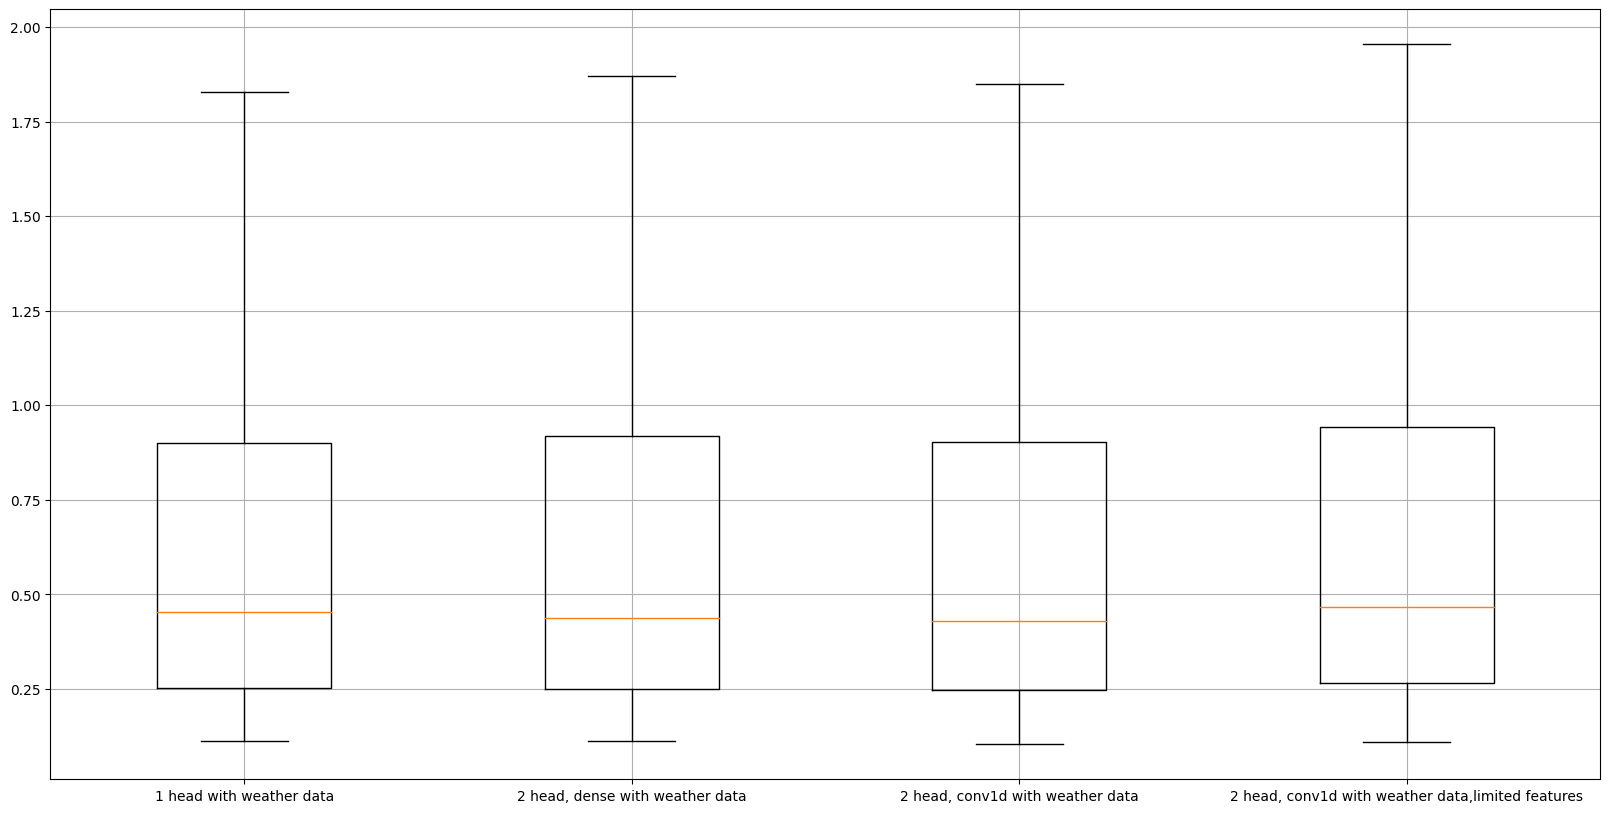

In [128]:
df = pd.DataFrame(dict(with_weather_data_=[x for x in fold_statistic_train_with_weather_data.model_statistic[0].values if x is not np.nan],with_weather_data_head2=[x for x in fold_statistic_train_with_weather_head2.model_statistic[0].values if x is not np.nan],
 with_weather_data_head2_v2=[x for x in fold_statistic_train_with_weather_head2_v2.model_statistic[0].values if x is not np.nan],
 with_weather_data_head2_v2_lim_featues=[x for x in fold_statistic_train_with_weather_head2_v2_lim_features.model_statistic[0].values if x is not np.nan]))

plt.figure(1,figsize=(20,10))
plt.grid(True)
plt.boxplot(df.dropna(),showfliers=False)
plt.xticks([1,2,3,4],['1 head with weather data','2 head, dense with weather data','2 head, conv1d with weather data','2 head, conv1d with weather data,limited features'])
plt.plot()

In [129]:
df.describe()

with_weather_data_  with_weather_data_head2  \
count          429.000000               429.000000   
mean             0.677437                 0.700948   
std              0.678700                 0.774737   
min              0.113073                 0.110971   
25%              0.252455                 0.249250   
50%              0.452581                 0.438309   
75%              0.900102                 0.917768   
max              6.723257                 7.163000   

       with_weather_data_head2_v2  with_weather_data_head2_v2_lim_featues  
count                  429.000000                              429.000000  
mean                     0.689039                                0.714446  
std                      0.740556                                0.762079  
min                      0.103477                                0.109483  
25%                      0.246716                                0.265281  
50%                      0.429317                                0.467454  
75%                      0.901911                                0.941605  
max                      6.902657                                7.528967

#### Conclusion

Just adding a 2 head model with 75 parameters as dense layer decreases the accuracy on the training and test set. But the performance is almost as good when the second head is also a Conv1D layer.

This model architecture has the advantage, that the customer can use the desired sales price as configurable variable.

### investigate correlation of features

Calculate the pearson correlation for all time series. The correlation value is in range [-1..1]. An absolute value sorting is used because when a correlation is close to -1 it is an almost perfect correlation with an inverted sign that might have a positive impact in training as well.

In [54]:
xy = []
for frame in folds_weather_data[0].frames:
    x,y = folds_weather_data[0].frames[0].wg.get_xy_train()
    xy.append(pd.concat([x.reset_index(drop=True),y.reset_index(drop=True)],axis=1))

xy = pd.concat(xy,axis=0)

xy_corr = xy.corr(method="pearson")
xy_corr.sort_values('OrderedQuantity',ascending=False,key=abs)["OrderedQuantity"]

OrderedQuantity                    1.000000
TotalPrecip3                       0.702651
UnitPrice7                        -0.634251
OrderDateTotalPrecip2              0.628032
MaxTemp3                          -0.587034
                                     ...   
OrderDateNumberOfSundaysBefore          NaN
OrderDateNumberOfSundaysBefore1         NaN
OrderDateNumberOfSundaysBefore2         NaN
OrderDateNumberOfSundaysBefore3         NaN
OrderDateNumberOfSundaysBefore4         NaN
Name: OrderedQuantity, Length: 324, dtype: float64

#### Conclusion

The Features __OrderDateNumberOfSundaysBefore__ are useless (No correlation). Most of the other features have correlation to the ordered Quantity. Because these are time related features it's difficult to see from this correlation matrix with features are more important than others.